# <b>Binary Classification with a Tabular Credit Card Fraud Dataset</b>

In [ ]:
# !pip install catboost

## 1. Import Libraries

In [3]:
import os
import random
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgbm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

### 1-1. Fixed Seed

In [4]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)

## 2. Load Data
`train.csv`: 학습 데이터, 타겟: Class<br>
`test.csv`: 테스트 데이터 <br>

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### 2-1. 데이터 설명

In [6]:
def data_describe(df, title):
    print(f'====================== {title} Data Describe ======================')
    print(f'Row: {df.shape[0]}, Column: {df.shape[1]}')
    columns = df.columns
    data_type = []

    for col in columns:
        data_type.append(df[col].dtype)

    n_uniq = df.nunique()
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uniq, n_miss))
    variable_desc = pd.DataFrame(names, columns=['Column', 'Dtype', 'Unique levels', 'Missing Count'])
    print(variable_desc)

In [7]:
data_describe(train, 'Train')

====================== Train Data Describe ======================
Row: 219129, Column: 32
    Column    Dtype  Unique levels  Missing Count
0       id    int64         219129              0
1     Time  float64          36845              0
2       V1  float64         217723              0
3       V2  float64         217729              0
4       V3  float64         217700              0
5       V4  float64         217715              0
6       V5  float64         217661              0
7       V6  float64         217594              0
8       V7  float64         217735              0
9       V8  float64         217679              0
10      V9  float64         217681              0
11     V10  float64         217722              0
12     V11  float64         217680              0
13     V12  float64         217739              0
14     V13  float64         217760              0
15     V14  float64         217726              0
16     V15  float64         217721              0
17     V16

In [8]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [9]:
data_describe(test, 'Test')

====================== Test Data Describe ======================
Row: 146087, Column: 31
    Column    Dtype  Unique levels  Missing Count
0       id    int64         146087              0
1     Time  float64          23662              0
2       V1  float64         145194              0
3       V2  float64         145218              0
4       V3  float64         145117              0
5       V4  float64         145164              0
6       V5  float64         145154              0
7       V6  float64         145136              0
8       V7  float64         145234              0
9       V8  float64         145199              0
10      V9  float64         145188              0
11     V10  float64         145215              0
12     V11  float64         145173              0
13     V12  float64         145213              0
14     V13  float64         145236              0
15     V14  float64         145191              0
16     V15  float64         145213              0
17     V16 

In [10]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,...,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,...,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,...,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,...,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,...,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98


In [11]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

## 3. EDA & Preprocessing

In [12]:
num_features = ['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
                'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

target = 'Class'

### 3-1. Numerical distribution

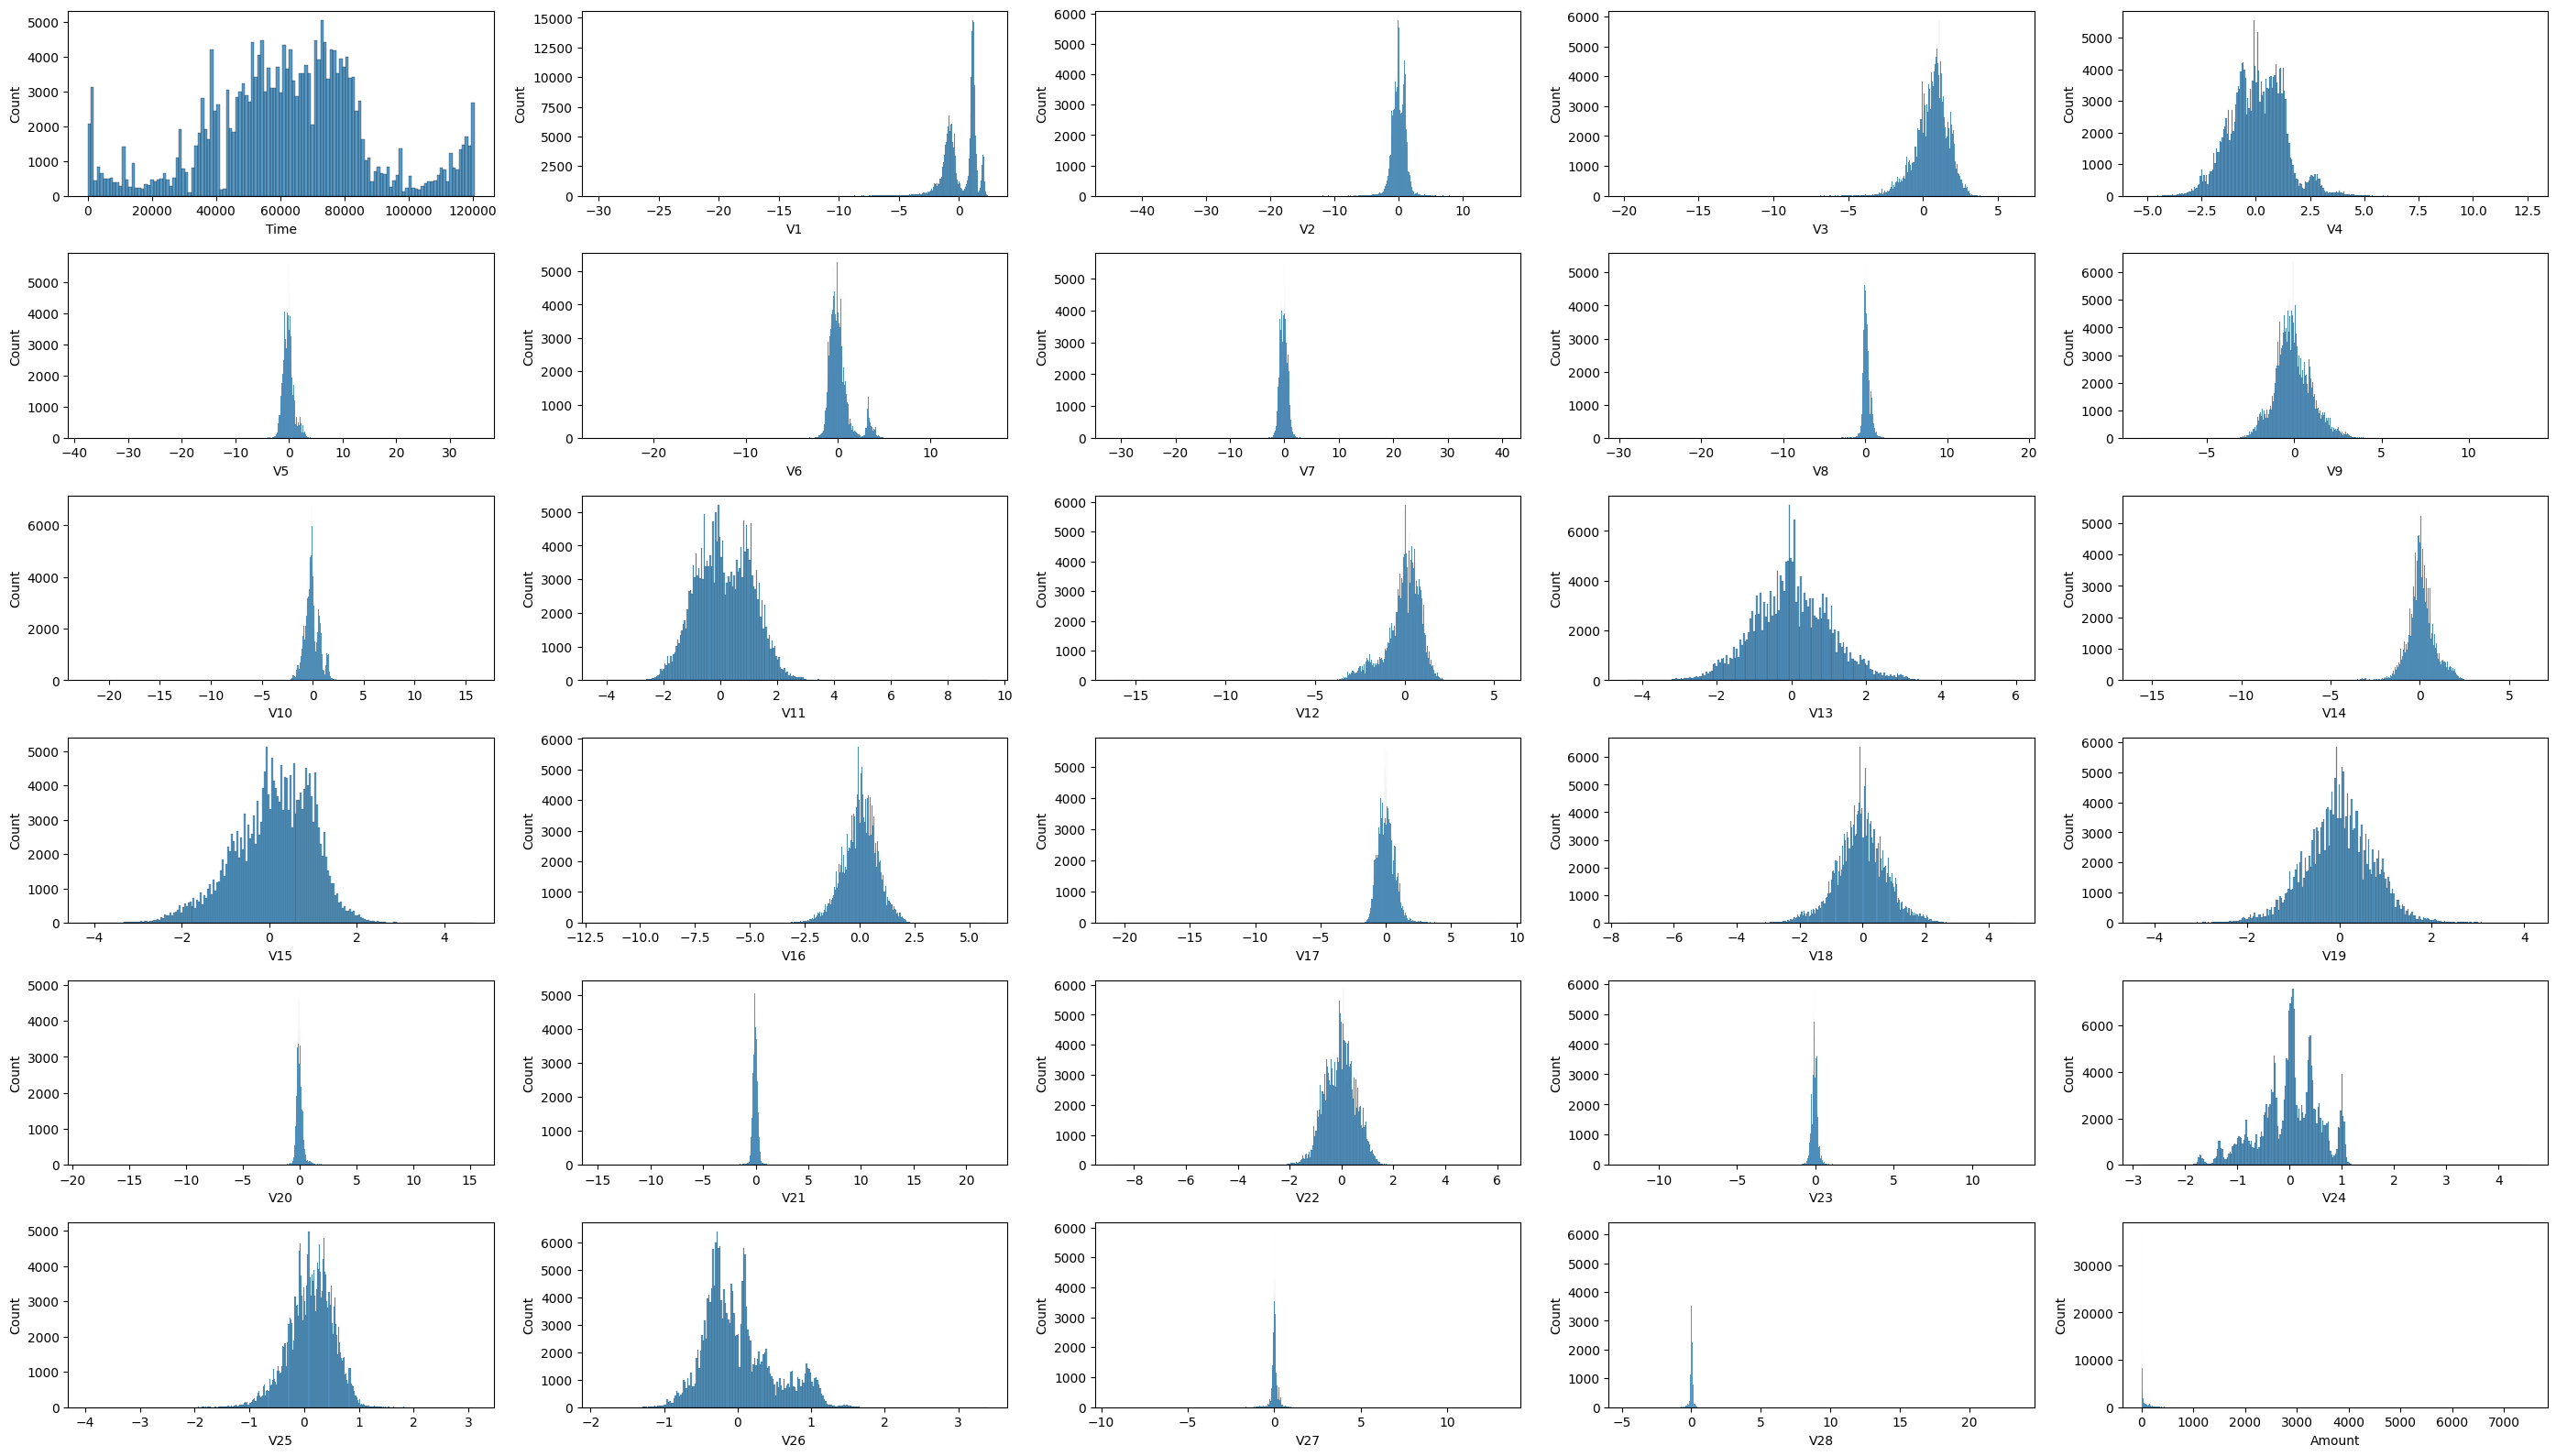

In [13]:
# Train set
fig, axes = plt.subplots(6, 5, figsize=(28, 16))
for i, j in zip(num_features, axes.flatten()):
    sns.histplot(train[i], ax=j)
fig.tight_layout()
plt.show()

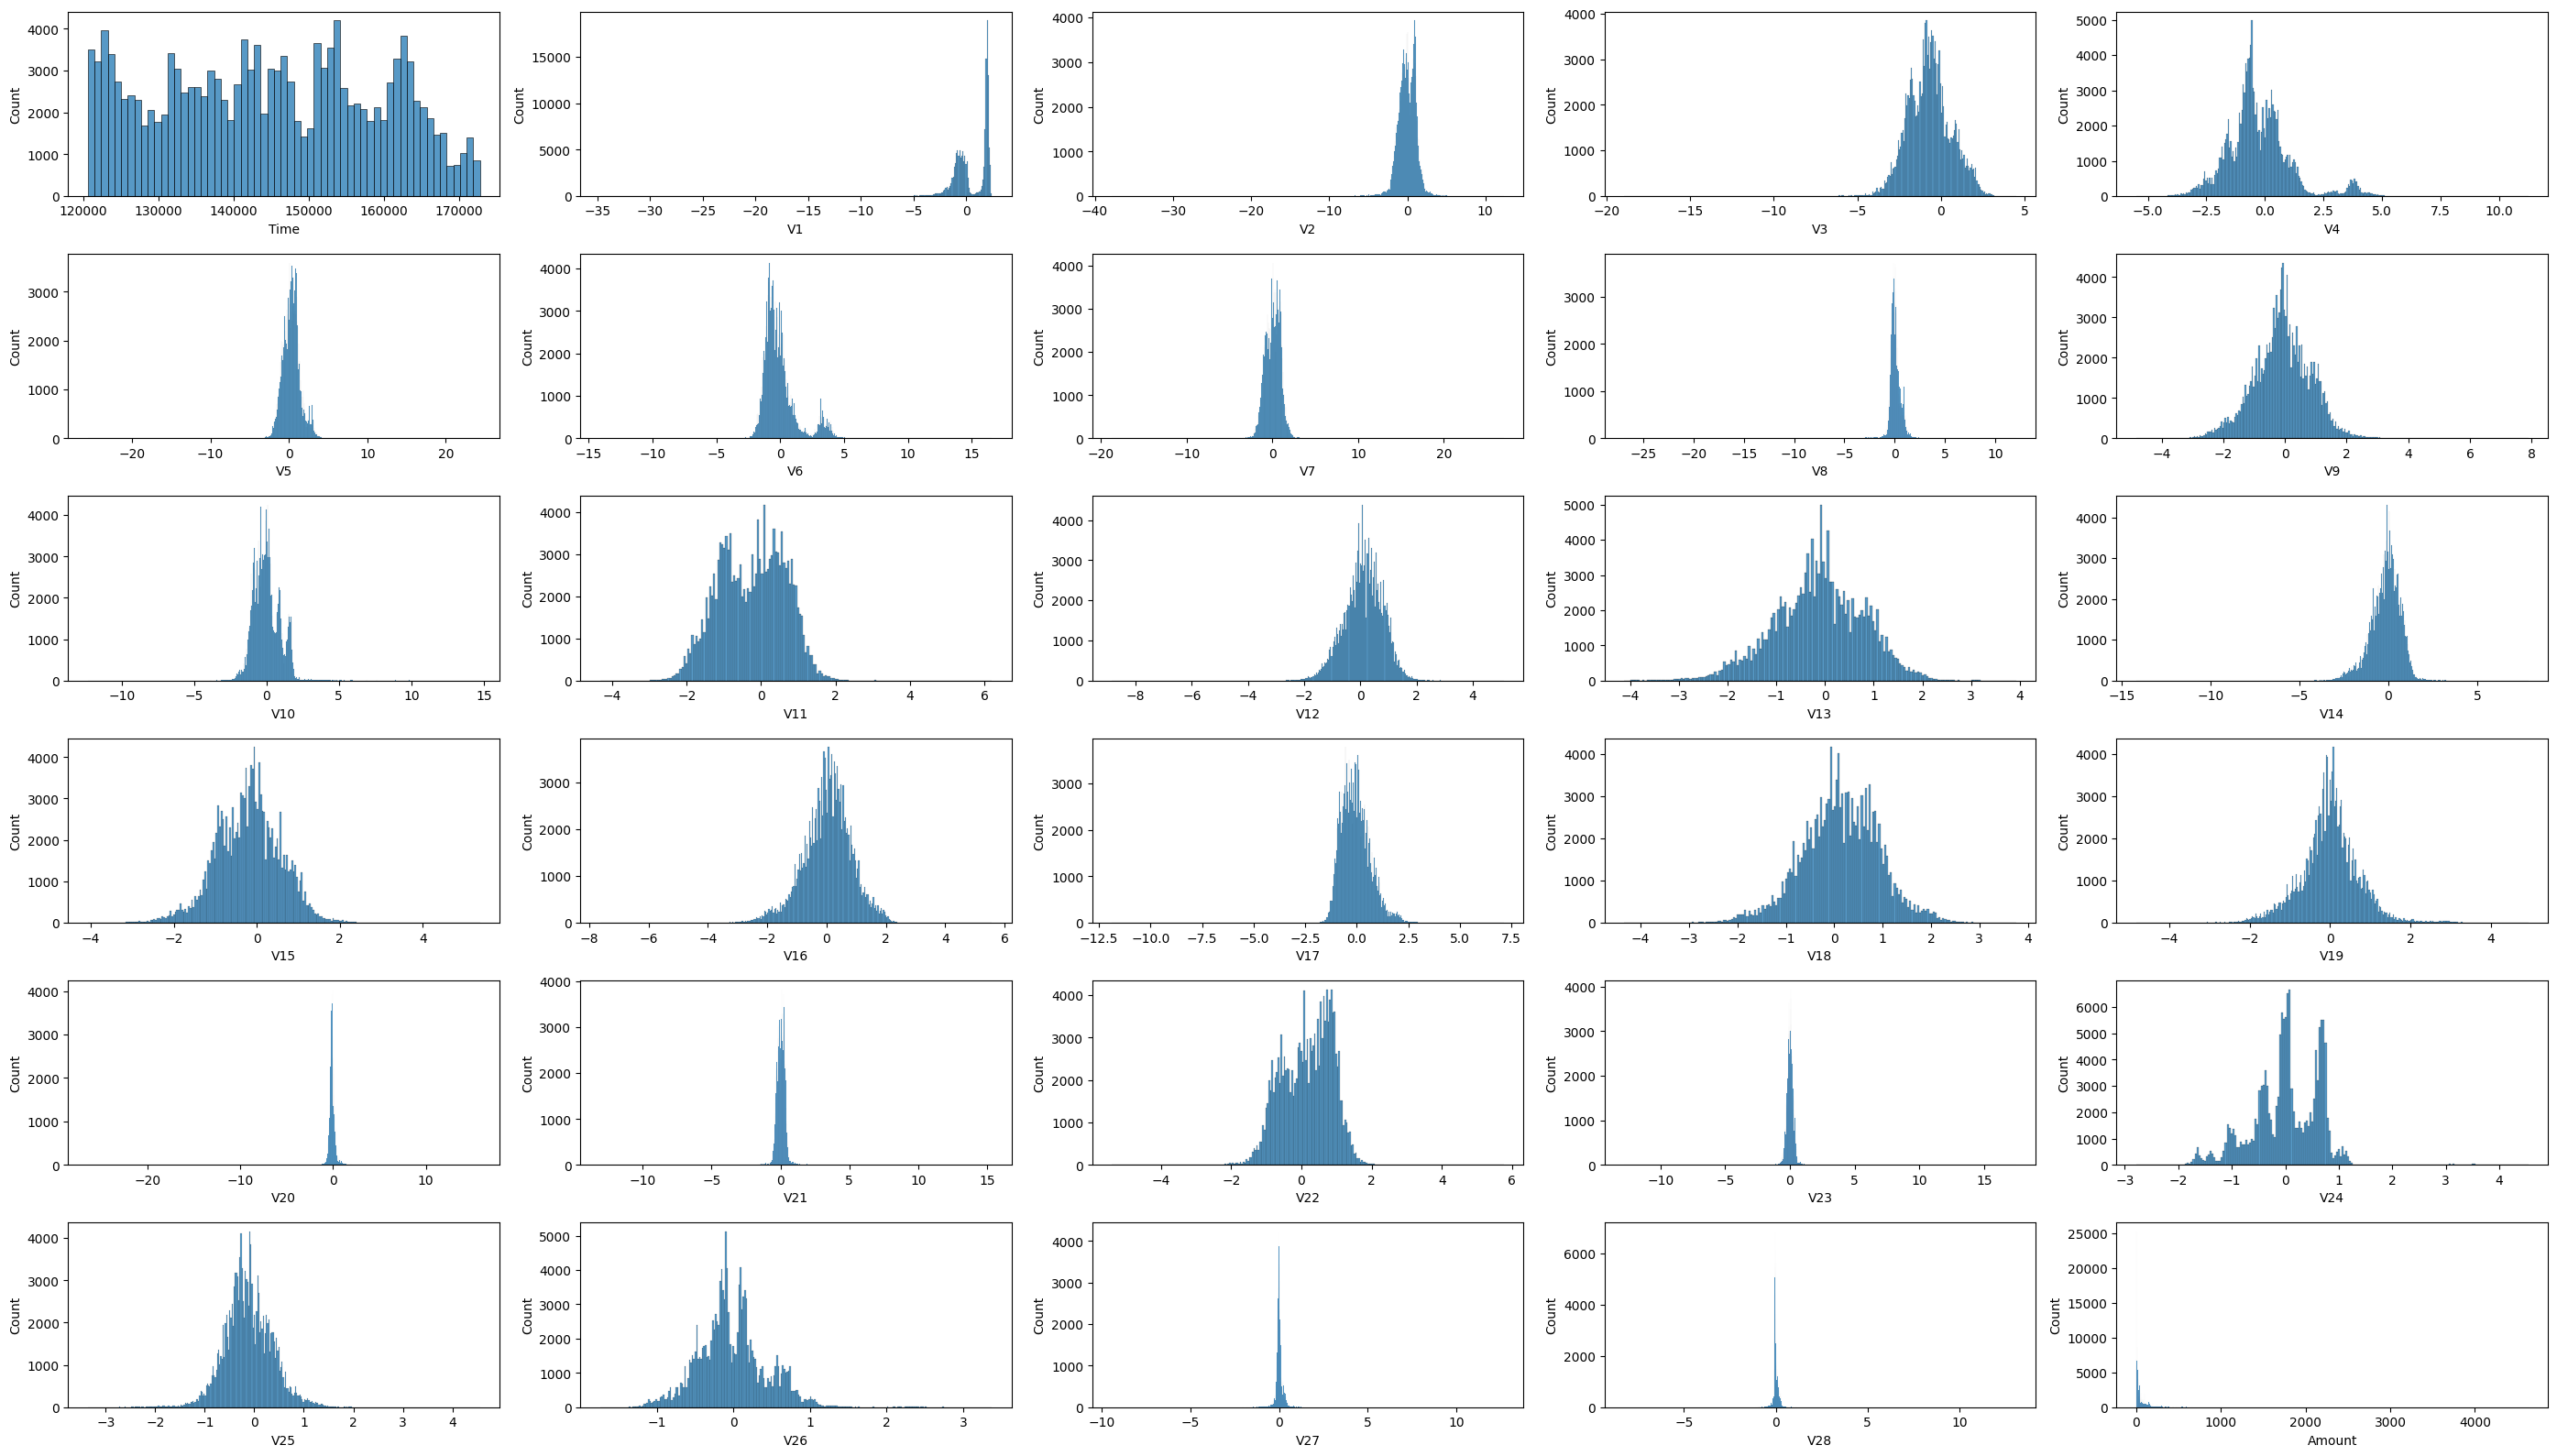

In [14]:
# Test set
fig, axes = plt.subplots(6, 5, figsize=(28, 16))
for i, j in zip(num_features, axes.flatten()):
    sns.histplot(test[i], ax=j)
fig.tight_layout()
plt.show()

### 3-2. Target distribution

In [15]:
# Train Set
print('Train Set')
display(pd.DataFrame(train['Class'].value_counts()).reset_index().rename(columns={'index':'Class', 'Attrition':'count'}))

Train Set


,Class,Class
0,0,218660
1,1,469


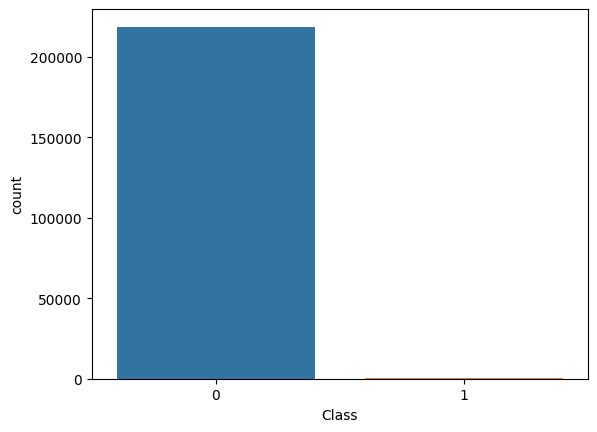

In [16]:
sns.countplot(x=train['Class'])
plt.show()

### 3-3. Correlation graph

In [17]:
def show_corr_heatmap(df, title):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(25, 20))
    plt.title(title)
    sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', vmax=1, vmin=-1,
                square=True, mask = mask, cmap='RdYlBu_r')
    plt.show()

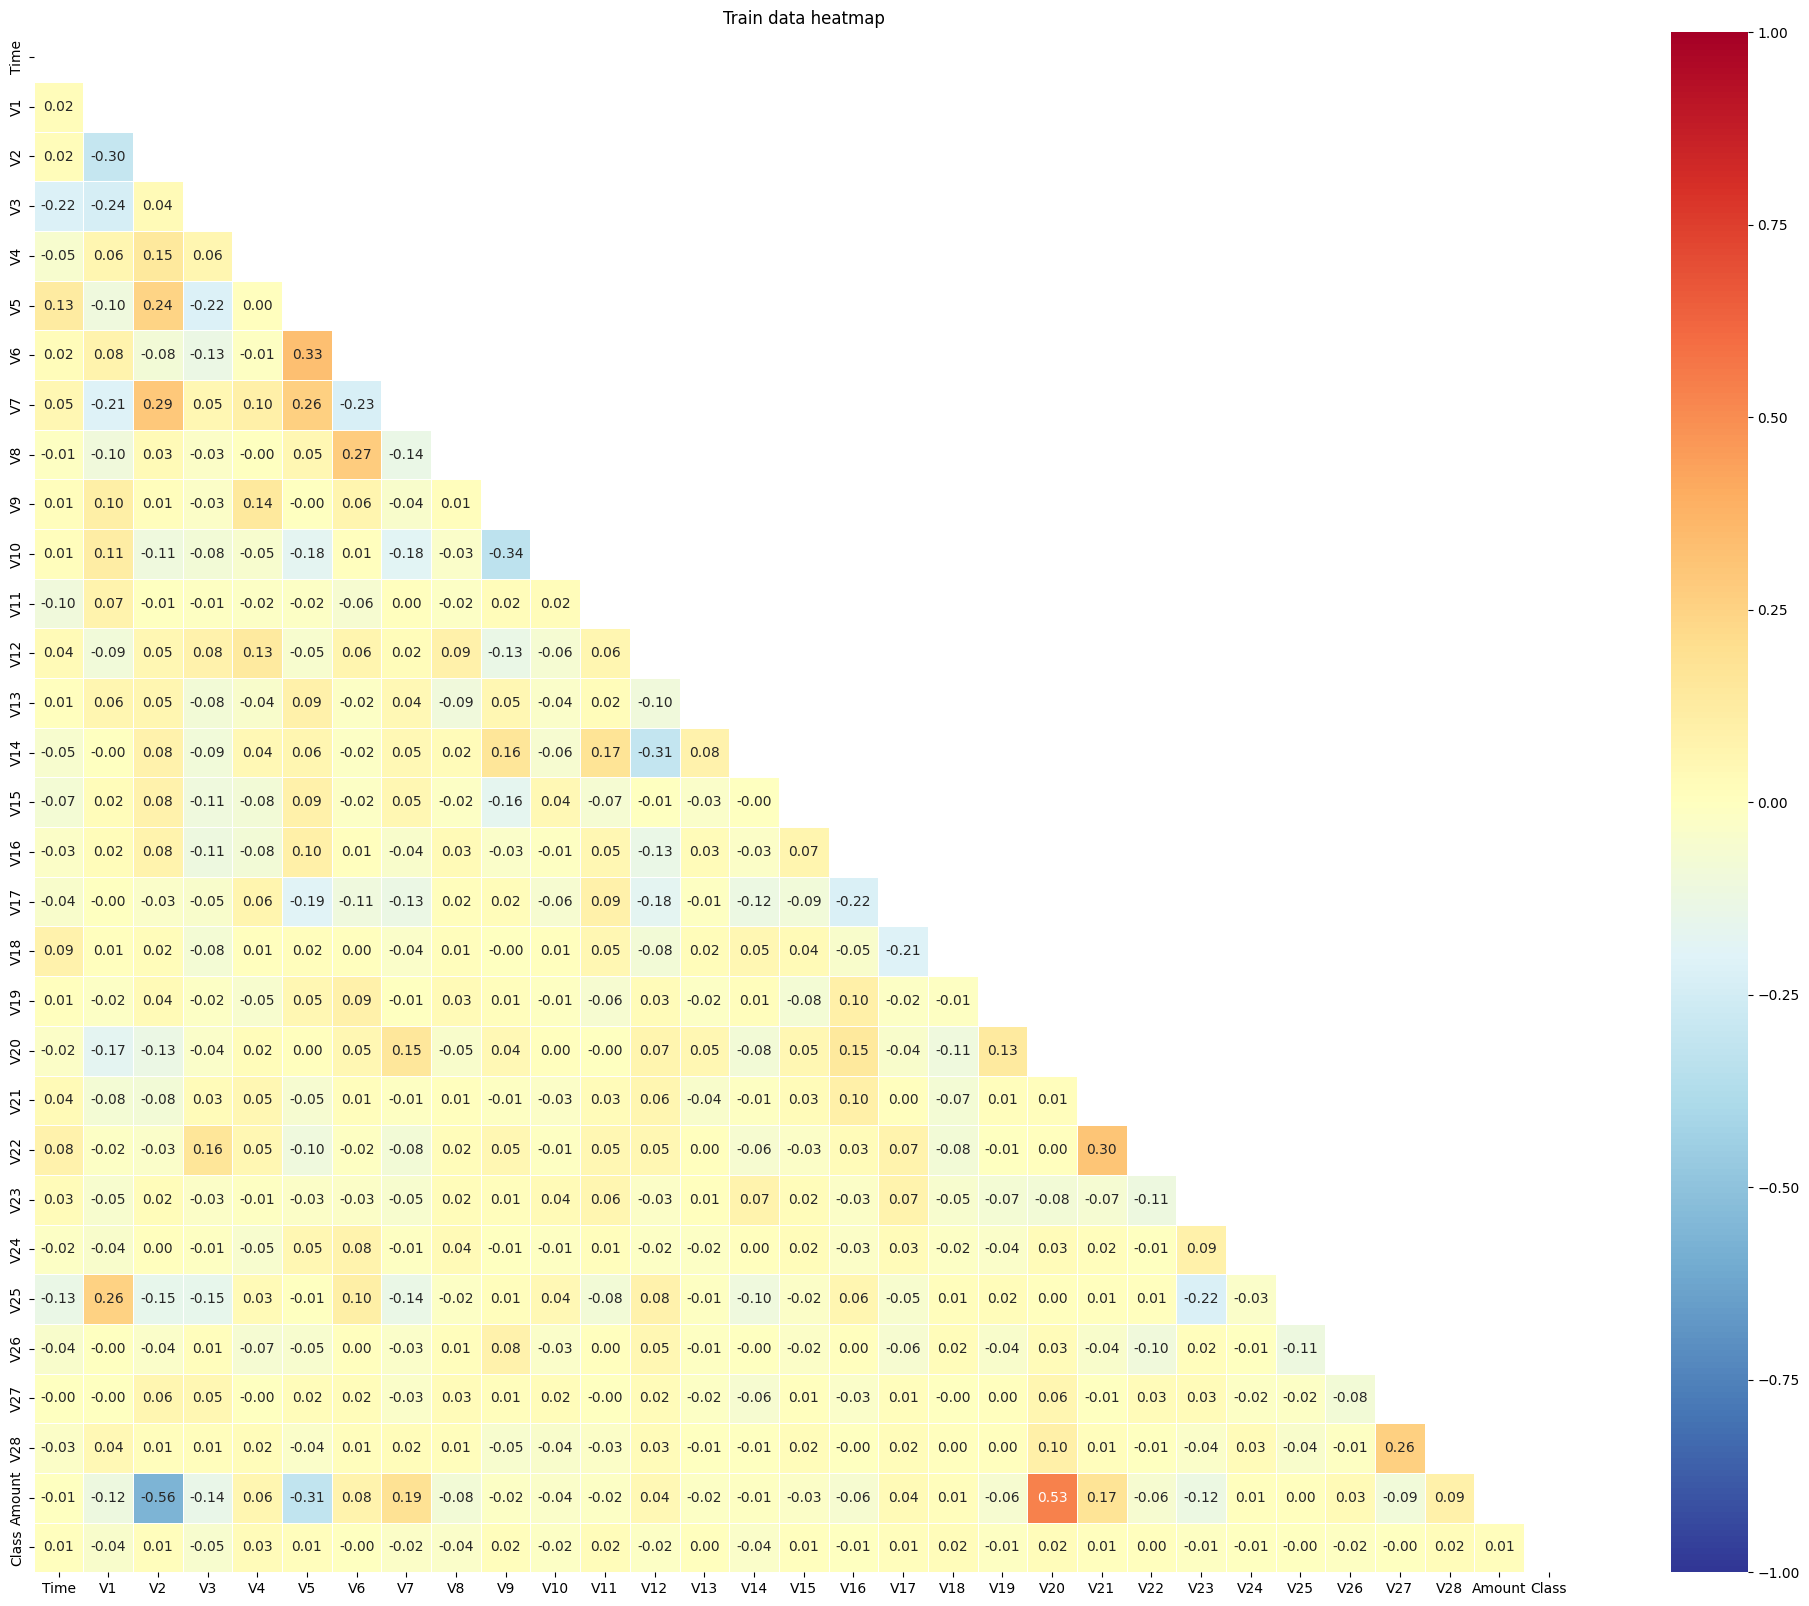

In [18]:
show_corr_heatmap(train, 'Train data heatmap')

## 4. Train Model
- 평가지표: `area under the ROC curve(AUC)`

In [19]:
train.reset_index(inplace=True, drop=True)

features = train.drop([target], axis=1).columns

In [20]:
clfs = []
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

### 4-1. Train XGBoost Model

In [21]:
scores1 = []

params = {'min_child_weight': 96,
          'max_depth': 7,
          'learning_rate': 0.18,
          'subsample': 0.95,
          'colsample_bytree': 0.95,
          'reg_lambda': 1.50,
          'reg_alpha': 1.50,
          'gamma': 1.50,
          'max_bin': 512,
          'objective': 'binary:logistic',
          'tree_method': 'hist'}

for i, (train_index, val_index) in enumerate(kf.split(train, y=train['Class'])):
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]

    clf = XGBClassifier(**params,
                        n_estimators=20000,
                        seed=42)

    clf.fit(X_train.values, y_train,
            early_stopping_rounds=100,
            eval_set=[(X_val.values, y_val)],
            eval_metric=['auc'],
            verbose=1000)

    preds1 = clf.predict_proba(X_val.values)
    auc1 = roc_auc_score(y_val, preds1[:, 1])

    clfs.append(clf)
    scores1.append(auc1)
    print(f'Score on fold {i} AUC: {auc1}')
    print('='*75)

print(f'Mean score across all folds AUC: {np.mean(scores1)}')

[0]	validation_0-auc:0.50000
[203]	validation_0-auc:0.81784
Score on fold 0 AUC: 0.8243790515149334
[0]	validation_0-auc:0.50000
[143]	validation_0-auc:0.83231
Score on fold 1 AUC: 0.8426513717011352
[0]	validation_0-auc:0.50000
[185]	validation_0-auc:0.80300
Score on fold 2 AUC: 0.8070238259728988
[0]	validation_0-auc:0.50000
[196]	validation_0-auc:0.87640
Score on fold 3 AUC: 0.8846445759568435
[0]	validation_0-auc:0.50000
[260]	validation_0-auc:0.80934
Score on fold 4 AUC: 0.817219388499779
[0]	validation_0-auc:0.50000
[235]	validation_0-auc:0.78948
Score on fold 5 AUC: 0.7953755076860802
[0]	validation_0-auc:0.50000
[217]	validation_0-auc:0.81218
Score on fold 6 AUC: 0.8150222535326389
[0]	validation_0-auc:0.50000
[143]	validation_0-auc:0.81069
Score on fold 7 AUC: 0.8247522141632496
[0]	validation_0-auc:0.50000
[335]	validation_0-auc:0.81231
Score on fold 8 AUC: 0.8144481571506136
[0]	validation_0-auc:0.50000
[232]	validation_0-auc:0.78567
Score on fold 9 AUC: 0.7885027976727816
M

====================XGBoost====================


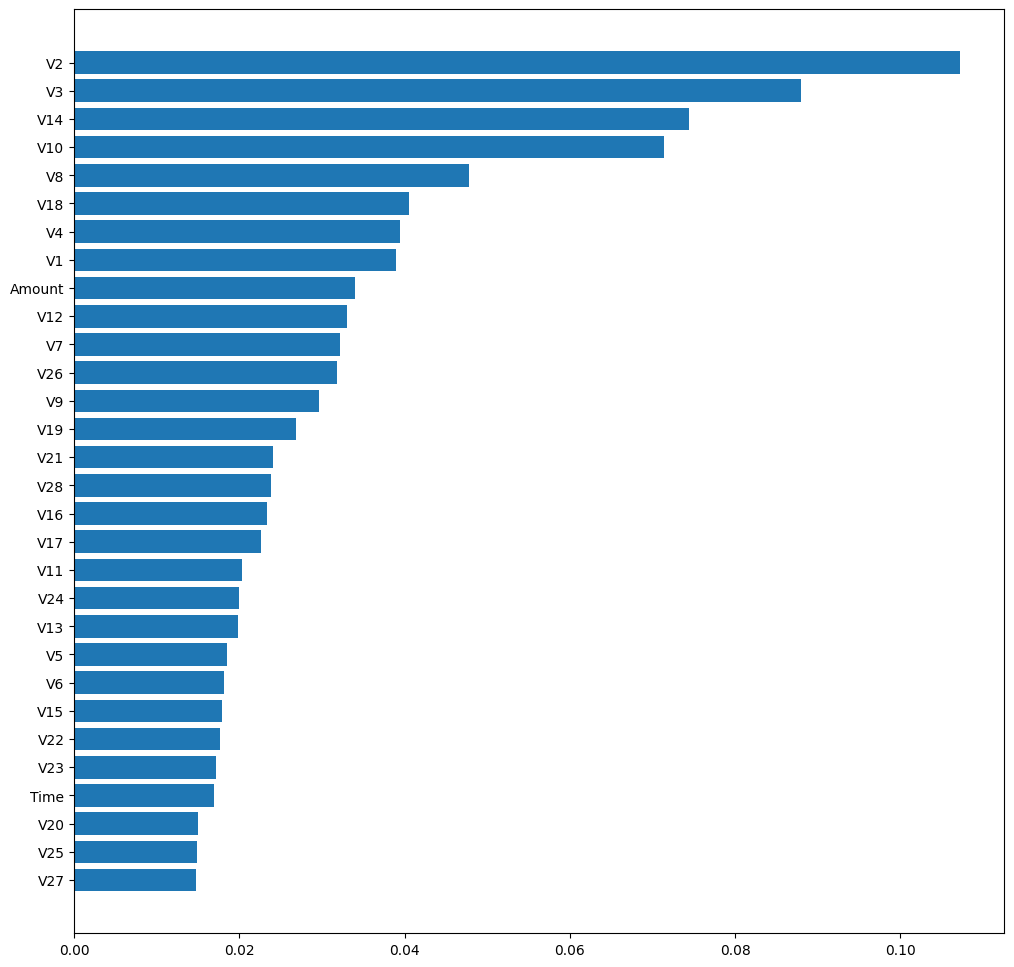

In [22]:
plt.figure(figsize=(12,12))
imp = np.zeros(30)
for clf in clfs[:10]:
    imp+= clf.feature_importances_

print('====================XGBoost====================')
plt.barh([features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

### 4-2. Train LightGBM Model

In [23]:
scores1 = []

params = {'learning_rate': 0.1,
          'num_leaves': 195,
          'max_depth': 9,
          'min_data_in_leaf': 46,
          'lambda_l1': 0.01,
          'lambda_l2': 0.6,
          'min_gain_to_split': 1.42,
          'bagging_fraction': 0.45,
          'feature_fraction': 0.3}

for i, (train_index, val_index) in enumerate(kf.split(train, y=train['Class'])):
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]

    clf = lgbm.LGBMClassifier(n_estimators=20000,
                              metric='auc',
                              random_state=42)

    clf.fit(X_train.values, y_train,
            eval_set=[(X_val.values, y_val)],
            eval_metric=['auc'],
            callbacks=[lgbm.early_stopping(100, verbose=True)])

    preds1 = clf.predict_proba(X_val.values)
    auc1 = roc_auc_score(y_val, preds1[:, 1])

    clfs.append(clf)
    scores1.append(auc1)
    print(f'Score on fold {i} AUC: {auc1}')
    print('='*75)

print(f'Mean score across all folds AUC: {np.mean(scores1)}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	valid_0's auc: 0.700294
Score on fold 0 AUC: 0.7010208212108179
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.669933
Score on fold 1 AUC: 0.6699325290794412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.628066
Score on fold 2 AUC: 0.6280658206367217
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	valid_0's auc: 0.739102
Score on fold 3 AUC: 0.738400820471304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.693658
Score on fold 4 AUC: 0.6936577918501666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.65676
Score on fold 5 AUC: 0.6563045513193514
Traini

====================LGBM====================


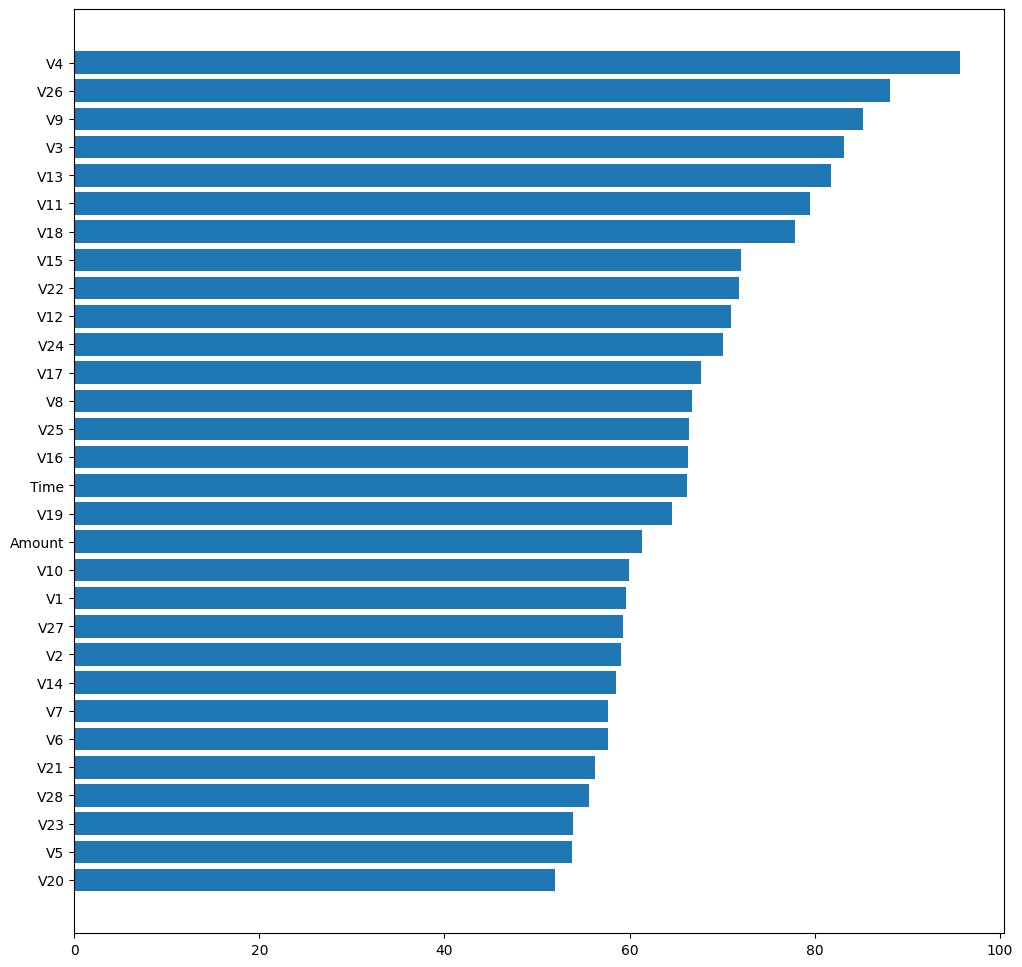

In [24]:
plt.figure(figsize=(12,12))
imp = np.zeros(30)
for clf in clfs[10:20]:
    imp+= clf.feature_importances_

print('====================LGBM====================')
plt.barh([features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

### 4-3. Train CatBoost Model

In [25]:
scores1 = []

params = {'learning_rate': 0.03,
          'depth': 4,
          'l2_leaf_reg': 0.014,
          'colsample_bylevel': 0.06,
          'min_data_in_leaf': 12,
          'boosting_type': 'Plain',
          'bootstrap_type': 'Bernoulli'}

for i, (train_index, val_index) in enumerate(kf.split(train, y=train['Class'])):
    X_train, X_val = train[features].loc[train_index], train[features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]

    clf = CatBoostClassifier(**params,
                             iterations=20000,
                             random_state=42)

    clf.fit(X_train.values, y_train,
            eval_set=(X_val.values, y_val),
            early_stopping_rounds=100, verbose=1000)

    preds1 = clf.predict_proba(X_val.values)
    auc1 = roc_auc_score(y_val, preds1[:, 1])

    clfs.append(clf)
    scores1.append(auc1)
    print(f'Score on fold {i} AUC: {auc1}')
    print('='*75)

print(f'Mean score across all folds AUC: {np.mean(scores1)}')

0:	learn: 0.6041239	test: 0.6041992	best: 0.6041992 (0)	total: 81ms	remaining: 26m 59s
1000:	learn: 0.0115834	test: 0.0139731	best: 0.0139695 (968)	total: 27.2s	remaining: 8m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.01384465802
bestIteration = 1183

Shrink model to first 1184 iterations.
Score on fold 0 AUC: 0.7931696153165022
0:	learn: 0.6037398	test: 0.6038934	best: 0.6038934 (0)	total: 26.4ms	remaining: 8m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.01292155761
bestIteration = 569

Shrink model to first 570 iterations.
Score on fold 1 AUC: 0.8247196171652872
0:	learn: 0.6034516	test: 0.6036265	best: 0.6036265 (0)	total: 26.5ms	remaining: 8m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.01350256715
bestIteration = 617

Shrink model to first 618 iterations.
Score on fold 2 AUC: 0.8081447734849208
0:	learn: 0.6039426	test: 0.6040888	best: 0.6040888 (0)	total: 42ms	remaining: 13m 59s
Stopped by overf

====================CatBoost====================


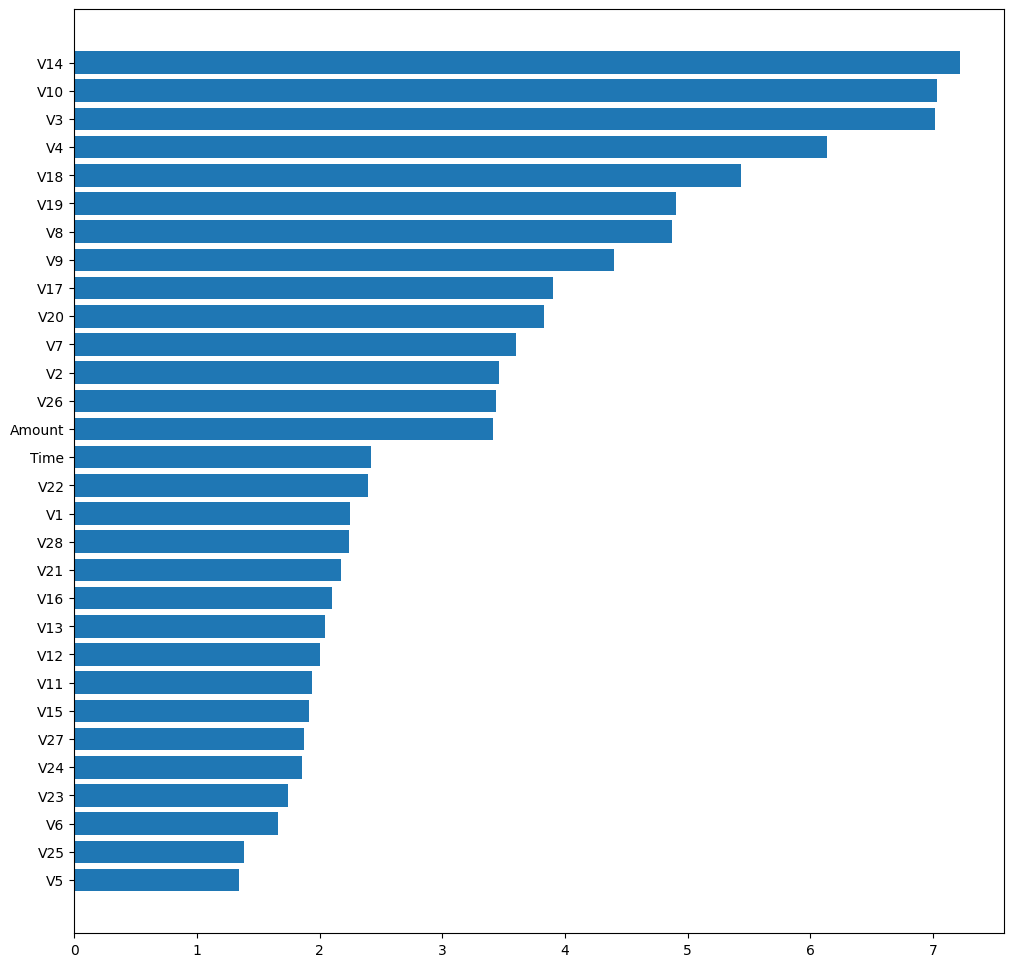

In [26]:
plt.figure(figsize=(12,12))
imp = np.zeros(30)
for clf in clfs[20:30]:
    imp+= clf.feature_importances_

print('====================CatBoost====================')
plt.barh([features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

## 5. Submission

In [27]:
test_preds1 = []
test_preds2 = []
test_preds3 = []

for clf in clfs[:10]:
    preds = clf.predict_proba(test[features].values)
    test_preds1.append(preds[:, 1])

for clf in clfs[10:20]:
    preds = clf.predict_proba(test[features].values)
    test_preds2.append(preds[:, 1])

for clf in clfs[20:30]:
    preds = clf.predict_proba(test[features].values)
    test_preds3.append(preds[:, 1])

In [28]:
test_preds1 = np.stack(test_preds1).mean(0)
test_preds2 = np.stack(test_preds2).mean(0)
test_preds3 = np.stack(test_preds3).mean(0)

In [29]:
test_preds = test_preds1*0.6 + test_preds2*0.05 + test_preds3*0.35

In [30]:
submission = pd.read_csv('sample_submission.csv')
submission['Class'] = test_preds
submission.head()

,id,Class
0,219129,0.001979
1,219130,0.000942
2,219131,0.000711
3,219132,0.003119
4,219133,0.003090


In [31]:
submission.to_csv('submission.csv', index=False)